In [ ]:
import copy
import os
from pathlib import Path
from typing import Optional

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from torchvision import datasets, transforms
from torchvision.models import ResNet34_Weights, resnet34
from torchvision.utils import make_grid

import random

In [ ]:
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Ensures deterministic behavior in cuDNN
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Random seed set to {seed}")

set_seed(42)

In [2]:
DATA_ROOT = Path("datasets")
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_WORKERS = max(1, (os.cpu_count() or 1) // 2)

IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

def create_dataloaders(data_root: Path,
                       batch_size: int = BATCH_SIZE,
                       img_size: int = IMG_SIZE,
                       num_workers: int = NUM_WORKERS):
    """Create ImageFolder datasets with augmentation-aware dataloaders."""
    data_root = Path(data_root)
    if not data_root.exists():
        raise FileNotFoundError(f"Dataset root not found: {data_root.resolve()}")

    train_transforms = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.RandomAffine(degrees=20, scale=(0.9, 1.1)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(p=0.2),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ])

    eval_transforms = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ])

    datasets_map = {
        "train": datasets.ImageFolder(root=data_root / "train", transform=train_transforms),
        "val": datasets.ImageFolder(root=data_root / "val", transform=eval_transforms),
    }

    try:
        datasets_map["test"] = datasets.ImageFolder(root=data_root / "test", transform=eval_transforms)
    except (FileNotFoundError, ValueError):
        pass

    dataloaders = {
        split: DataLoader(ds,
                          batch_size=batch_size,
                          shuffle=(split == "train"),
                          num_workers=num_workers,
                          pin_memory=torch.cuda.is_available())
        for split, ds in datasets_map.items()
    }

    return dataloaders, datasets_map["train"].classes


dataloaders, class_names = create_dataloaders(DATA_ROOT)

for split, loader in dataloaders.items():
    print(f"{split}: {len(loader.dataset)} images across {len(class_names)} classes")

print(f"Classes: {class_names}")

train: 20000 images across 2 classes
val: 5000 images across 2 classes
Classes: ['cat', 'dog']


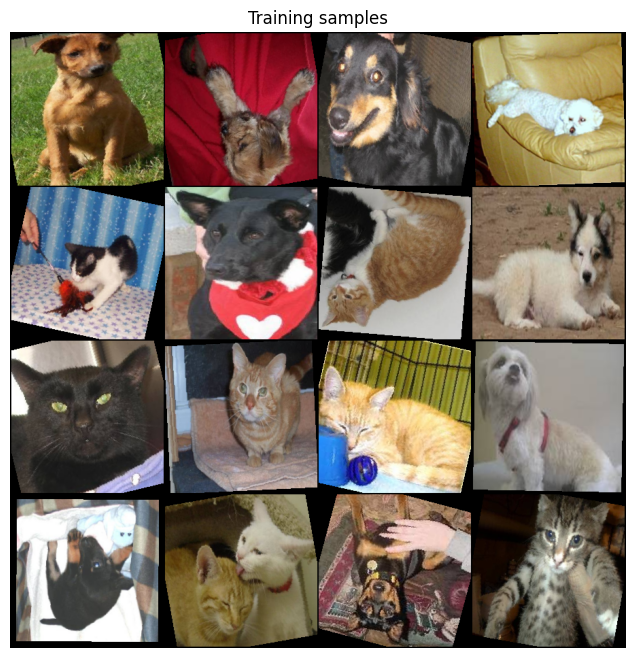

In [3]:
def visualize_batch(dataloader, n_images: int = 16, title: Optional[str] = None):
    """Display a grid of images from a dataloader batch."""
    if n_images < 1:
        raise ValueError("n_images must be at least 1")

    images, labels = next(iter(dataloader))
    n_images = min(n_images, images.size(0))
    images = images[:n_images].detach().cpu()

    mean = torch.tensor(IMAGENET_MEAN).view(-1, 1, 1)
    std = torch.tensor(IMAGENET_STD).view(-1, 1, 1)
    images = images * std + mean

    grid = make_grid(images, nrow=int(n_images**0.5) or 1, padding=2)
    np_img = grid.permute(1, 2, 0).numpy().clip(0, 1)

    plt.figure(figsize=(8, 8))
    plt.imshow(np_img)
    plt.axis("off")
    plt.title(title or "Sample batch")
    plt.show()


visualize_batch(dataloaders["train"], title="Training samples")

In [4]:
def get_device() -> torch.device:
    if torch.cuda.is_available():
        return torch.device("cuda")
    if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        return torch.device("mps")
    return torch.device("cpu")


def build_feature_extractor(num_classes: int) -> nn.Module:
    """Load a pretrained ResNet-34 and expose a trainable classifier head."""
    weights = ResNet34_Weights.IMAGENET1K_V1
    model = resnet34(weights=weights)
    for param in model.parameters():
        param.requires_grad = False
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model


def train_one_epoch(model: nn.Module,
                    dataloader: DataLoader,
                    criterion: nn.Module,
                    optimizer: torch.optim.Optimizer,
                    device: torch.device,
                    epoch: int,
                    total_epochs: int) -> tuple[float, float]:
    model.train()
    running_loss = 0.0
    running_corrects = 0
    samples = 0

    for inputs, labels in tqdm(dataloader,
                               desc=f"Train [{epoch + 1}/{total_epochs}]",
                               leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += outputs.argmax(dim=1).eq(labels).sum().item()
        samples += inputs.size(0)

    return running_loss / samples, running_corrects / samples


def evaluate(model: nn.Module,
             dataloader: Optional[DataLoader],
             criterion: nn.Module,
             device: torch.device,
             split: str,
             epoch: Optional[int] = None,
             total_epochs: Optional[int] = None) -> tuple[float, float]:
    if dataloader is None:
        return float("nan"), float("nan")

    model.eval()
    running_loss = 0.0
    running_corrects = 0
    samples = 0

    if epoch is not None and total_epochs is not None:
        desc = f"{split.capitalize()} [{epoch + 1}/{total_epochs}]"
    else:
        desc = split.capitalize()

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc=desc, leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += outputs.argmax(dim=1).eq(labels).sum().item()
            samples += inputs.size(0)

    if samples == 0:
        return float("nan"), float("nan")

    return running_loss / samples, running_corrects / samples


def train_feature_extractor(dataloaders: dict,
                            num_classes: int,
                            epochs: int = 5,
                            lr: float = 1e-3) -> tuple[nn.Module, dict[str, list[float]]]:
    train_loader = dataloaders.get("train")
    val_loader = dataloaders.get("val")
    if train_loader is None or val_loader is None:
        raise ValueError("Both 'train' and 'val' splits are required for training.")

    device = get_device()
    print(f"Using device: {device}")

    model = build_feature_extractor(num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    scheduler = StepLR(optimizer, step_size=max(epochs // 2, 1), gamma=0.1) if epochs > 1 else None

    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    best_weights = copy.deepcopy(model.state_dict())
    best_val_acc = 0.0

    for epoch in range(epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device, epoch, epochs)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device, split="val", epoch=epoch, total_epochs=epochs)

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        if scheduler is not None:
            scheduler.step()

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_weights = copy.deepcopy(model.state_dict())

        print(f"Epoch {epoch + 1}/{epochs} | Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

    model.load_state_dict(best_weights)
    print(f"Best validation accuracy: {best_val_acc:.4f}")

    test_loader = dataloaders.get("test")
    if test_loader is not None:
        test_loss, test_acc = evaluate(model, test_loader, criterion, device, split="test")
        print(f"Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}")

    return model, history


feature_model, training_history = train_feature_extractor(dataloaders,
                                                          num_classes=len(class_names),
                                                          epochs=5,
                                                          lr=1e-3)

Using device: cuda


Train [1/5]:   0%|          | 0/625 [00:00<?, ?it/s]

Val [1/5]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 1/5 | Train Loss: 0.1933 Acc: 0.9186 | Val Loss: 0.0741 Acc: 0.9756


Train [2/5]:   0%|          | 0/625 [00:00<?, ?it/s]

Val [2/5]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 2/5 | Train Loss: 0.1518 Acc: 0.9372 | Val Loss: 0.0674 Acc: 0.9768


Train [3/5]:   0%|          | 0/625 [00:00<?, ?it/s]

Val [3/5]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 3/5 | Train Loss: 0.1391 Acc: 0.9417 | Val Loss: 0.0633 Acc: 0.9780


Train [4/5]:   0%|          | 0/625 [02:00<?, ?it/s]

Val [4/5]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 4/5 | Train Loss: 0.1351 Acc: 0.9436 | Val Loss: 0.0633 Acc: 0.9774


Train [5/5]:   0%|          | 0/625 [00:00<?, ?it/s]

Val [5/5]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 5/5 | Train Loss: 0.1356 Acc: 0.9435 | Val Loss: 0.0641 Acc: 0.9776
Best validation accuracy: 0.9780


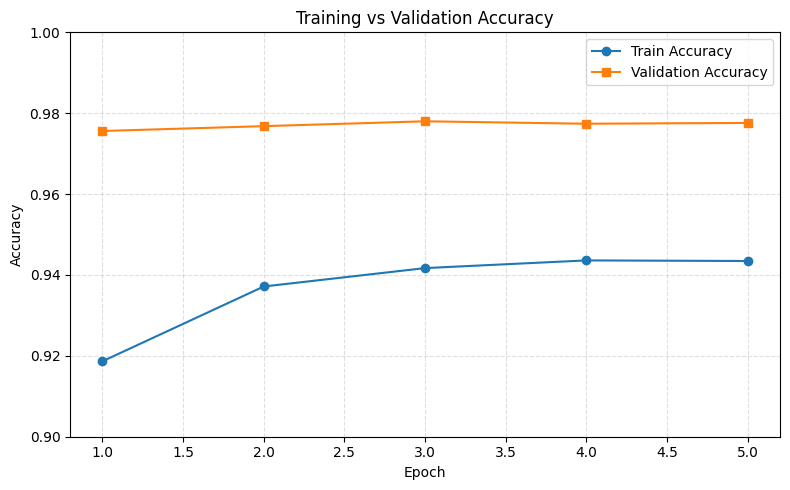

In [5]:
def plot_accuracy(history: dict[str, list[float]]):
    """Plot training and validation accuracy history."""
    epochs = range(1, len(history.get("train_acc", [])) + 1)
    if not epochs:
        raise ValueError("History is empty; run training before plotting.")

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, history["train_acc"], label="Train Accuracy", marker="o")
    plt.plot(epochs, history["val_acc"], label="Validation Accuracy", marker="s")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training vs Validation Accuracy")
    plt.ylim(0.90, 1.0)
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()


plot_accuracy(training_history)

In [6]:
def unfreeze_last_blocks(model: nn.Module, num_blocks: int = 2) -> nn.Module:
    """Enable gradient updates for the last few residual blocks and classifier."""
    blocks = list(model.layer4.children())
    if num_blocks > len(blocks):
        raise ValueError(f"Requested {num_blocks} blocks but model.layer4 has only {len(blocks)}")

    for block in blocks[-num_blocks:]:
        for param in block.parameters():
            param.requires_grad = True

    for param in model.fc.parameters():
        param.requires_grad = True

    return model


def fine_tune_model(model: nn.Module,
                     dataloaders: dict,
                     epochs: int = 15,
                     lr: float = 1e-5,
                     num_blocks_to_unfreeze: int = 2) -> tuple[nn.Module, dict[str, list[float]]]:
    train_loader = dataloaders.get("train")
    val_loader = dataloaders.get("val")
    if train_loader is None or val_loader is None:
        raise ValueError("Both 'train' and 'val' splits are required for fine-tuning.")

    device = get_device()
    model = model.to(device)
    model = unfreeze_last_blocks(model, num_blocks=num_blocks_to_unfreeze)

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    scheduler = StepLR(optimizer, step_size=max(epochs // 3, 1), gamma=0.5) if epochs > 1 else None

    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    best_weights = copy.deepcopy(model.state_dict())
    best_val_acc = 0.0

    for epoch in range(epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device, epoch, epochs)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device, split="val", epoch=epoch, total_epochs=epochs)

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        if scheduler is not None:
            scheduler.step()

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_weights = copy.deepcopy(model.state_dict())

        print(f"[Fine-tune] Epoch {epoch + 1}/{epochs} | Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

    model.load_state_dict(best_weights)
    print(f"Best validation accuracy after fine-tuning: {best_val_acc:.4f}")

    test_loader = dataloaders.get("test")
    if test_loader is not None:
        test_loss, test_acc = evaluate(model, test_loader, criterion, device, split="test")
        print(f"Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}")

    return model, history


feature_model, finetune_history = fine_tune_model(feature_model,
                                                  dataloaders,
                                                  epochs=10,
                                                  lr=1e-5,
                                                  num_blocks_to_unfreeze=2)


Train [1/10]:   0%|          | 0/625 [00:00<?, ?it/s]

Val [1/10]:   0%|          | 0/157 [00:00<?, ?it/s]

[Fine-tune] Epoch 1/10 | Train Loss: 0.1199 Acc: 0.9523 | Val Loss: 0.0493 Acc: 0.9822


Train [2/10]:   0%|          | 0/625 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a783757bf60>
Traceback (most recent call last):
  File "/home/bebekjk/code/ie4483/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/bebekjk/code/ie4483/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a783757bf60>
Traceback (most recent call last):
  File "/home/bebekjk/code/ie4483/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/bebekjk/cod

Val [2/10]:   0%|          | 0/157 [00:00<?, ?it/s]

[Fine-tune] Epoch 2/10 | Train Loss: 0.1007 Acc: 0.9595 | Val Loss: 0.0446 Acc: 0.9846


Train [3/10]:   0%|          | 0/625 [00:00<?, ?it/s]

Val [3/10]:   0%|          | 0/157 [00:00<?, ?it/s]

[Fine-tune] Epoch 3/10 | Train Loss: 0.0897 Acc: 0.9644 | Val Loss: 0.0427 Acc: 0.9838


Train [4/10]:   0%|          | 0/625 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a783757bf60>
Traceback (most recent call last):
  File "/home/bebekjk/code/ie4483/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/bebekjk/code/ie4483/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a783757bf60>
Traceback (most recent call last):
self._shutdown_workers()  File "/home/bebekjk/code/ie4483/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    
  File "/home/bebekjk/cod

Val [4/10]:   0%|          | 0/157 [00:00<?, ?it/s]

[Fine-tune] Epoch 4/10 | Train Loss: 0.0757 Acc: 0.9714 | Val Loss: 0.0401 Acc: 0.9856


Train [5/10]:   0%|          | 0/625 [00:00<?, ?it/s]

Val [5/10]:   0%|          | 0/157 [00:00<?, ?it/s]

[Fine-tune] Epoch 5/10 | Train Loss: 0.0730 Acc: 0.9704 | Val Loss: 0.0413 Acc: 0.9850


Train [6/10]:   0%|          | 0/625 [00:00<?, ?it/s]

Val [6/10]:   0%|          | 0/157 [00:00<?, ?it/s]

[Fine-tune] Epoch 6/10 | Train Loss: 0.0709 Acc: 0.9719 | Val Loss: 0.0410 Acc: 0.9856


Train [7/10]:   0%|          | 0/625 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a783757bf60>
Traceback (most recent call last):
  File "/home/bebekjk/code/ie4483/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/bebekjk/code/ie4483/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7a783757bf60>
^Traceback (most recent call last):
^  File "/home/bebekjk/code/ie4483/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^    self._shutdown_workers()^^

  File "/home/bebekjk/code/ie4483/.venv/lib/python3.12/site-packages/to

Val [7/10]:   0%|          | 0/157 [00:00<?, ?it/s]

[Fine-tune] Epoch 7/10 | Train Loss: 0.0660 Acc: 0.9737 | Val Loss: 0.0379 Acc: 0.9866


Train [8/10]:   0%|          | 0/625 [00:00<?, ?it/s]

Val [8/10]:   0%|          | 0/157 [00:00<?, ?it/s]

[Fine-tune] Epoch 8/10 | Train Loss: 0.0678 Acc: 0.9738 | Val Loss: 0.0391 Acc: 0.9860


Train [9/10]:   0%|          | 0/625 [00:00<?, ?it/s]

Val [9/10]:   0%|          | 0/157 [00:00<?, ?it/s]

[Fine-tune] Epoch 9/10 | Train Loss: 0.0644 Acc: 0.9751 | Val Loss: 0.0375 Acc: 0.9872


Train [10/10]:   0%|          | 0/625 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a783757bf60>Exception ignored in: 
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7a783757bf60>
  File "/home/bebekjk/code/ie4483/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
Traceback (most recent call last):
  File "/home/bebekjk/code/ie4483/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
            self._shutdown_workers()self._shutdown_workers()

  File "/home/bebekjk/code/ie4483/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
  File "/home/bebekjk/code/ie4483/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
if w.is_alive():    
if w.is_alive(): 
             ^^^^^^^^^^^^^^^^^^^^^^
^^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    
assert self

Val [10/10]:   0%|          | 0/157 [00:00<?, ?it/s]

[Fine-tune] Epoch 10/10 | Train Loss: 0.0570 Acc: 0.9782 | Val Loss: 0.0380 Acc: 0.9868
Best validation accuracy after fine-tuning: 0.9872


In [7]:
artifacts_dir = Path("artifacts")
artifacts_dir.mkdir(parents=True, exist_ok=True)
weights_path = artifacts_dir / "resnet34_finetuned.pth"
torch.save(feature_model.state_dict(), weights_path)
print(f"Saved fine-tuned weights to {weights_path}")

Saved fine-tuned weights to artifacts/resnet34_finetuned.pth


Combined epochs: 15 (feature extraction: 5, fine-tuning: 10)


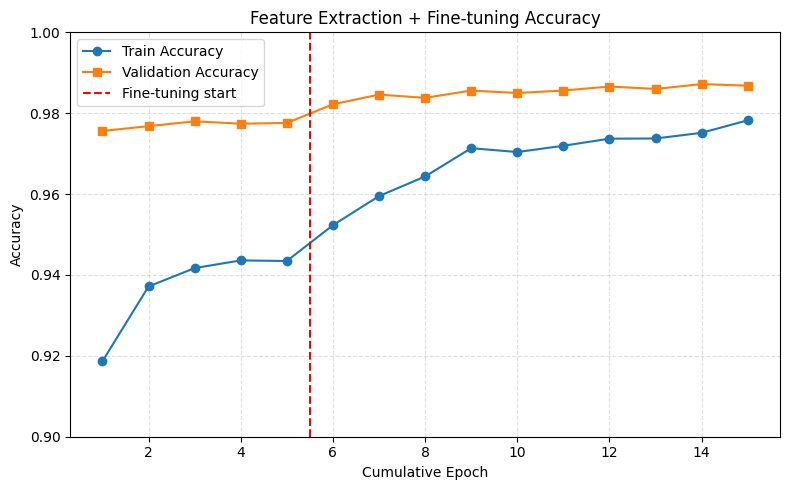

Feature extraction epochs: 1-5
Fine-tuning epochs: 6-15


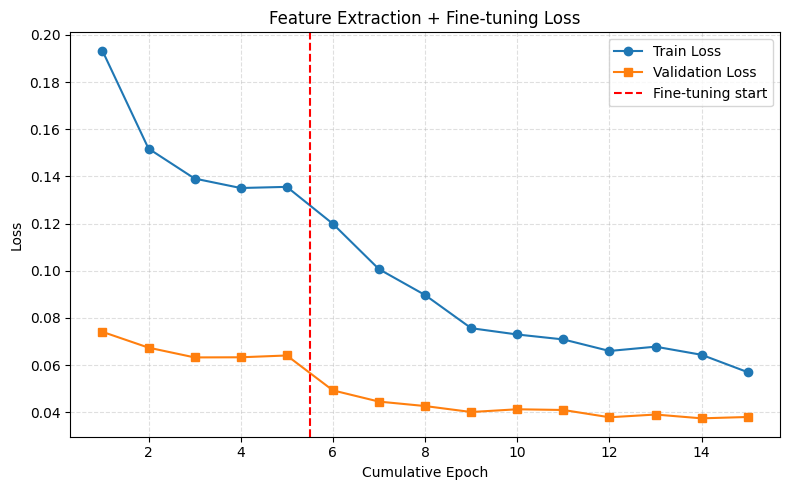

In [8]:
def combine_histories(initial: dict[str, list[float]], continued: dict[str, list[float]]):
    """Concatenate metric histories from feature extraction and fine-tuning runs."""
    if not initial or not continued:
        raise ValueError("Both initial and continued histories must be provided.")

    combined = {metric: list(initial.get(metric, [])) + list(continued.get(metric, []))
                for metric in set(initial) | set(continued)}

    initial_epochs = len(initial.get("train_acc", []))
    continued_epochs = len(continued.get("train_acc", []))
    epoch_index = np.arange(1, initial_epochs + continued_epochs + 1)

    boundary_epoch = initial_epochs
    return combined, epoch_index, boundary_epoch


def plot_combined_accuracy(initial_history: dict[str, list[float]],
                            continued_history: dict[str, list[float]]):
    combined, epoch_index, boundary = combine_histories(initial_history, continued_history)
    epoch_index = epoch_index[:15]

    plt.figure(figsize=(8, 5))
    plt.plot(epoch_index, combined["train_acc"][:15], label="Train Accuracy", marker="o")
    plt.plot(epoch_index, combined["val_acc"][:15], label="Validation Accuracy", marker="s")
    plt.axvline(boundary + 0.5, color="red", linestyle="--", linewidth=1.5, label="Fine-tuning start")
    plt.xlabel("Cumulative Epoch")
    plt.ylabel("Accuracy")
    plt.title("Feature Extraction + Fine-tuning Accuracy")
    plt.ylim(0.90, 1.0)
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"Feature extraction epochs: 1-{boundary}")
    print(f"Fine-tuning epochs: {boundary + 1}-{len(epoch_index)}")


def plot_combined_loss(initial_history: dict[str, list[float]],
                       continued_history: dict[str, list[float]]):
    combined, epoch_index, boundary = combine_histories(initial_history, continued_history)
    combined = combined
    epoch_index = epoch_index[:15]
    
    plt.figure(figsize=(8, 5))
    plt.plot(epoch_index, combined["train_loss"][:15], label="Train Loss", marker="o")
    plt.plot(epoch_index, combined["val_loss"][:15], label="Validation Loss", marker="s")
    plt.axvline(boundary + 0.5, color="red", linestyle="--", linewidth=1.5, label="Fine-tuning start")
    plt.xlabel("Cumulative Epoch")
    plt.ylabel("Loss")
    plt.title("Feature Extraction + Fine-tuning Loss")
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()


combined_history, combined_epochs, boundary_epoch = combine_histories(training_history, finetune_history)
print(f"Combined epochs: {len(combined_epochs)} (feature extraction: {boundary_epoch}, fine-tuning: {len(combined_epochs) - boundary_epoch})")
plot_combined_accuracy(training_history, finetune_history)
plot_combined_loss(training_history, finetune_history)